<a href="https://colab.research.google.com/github/dusdnKR/SWCON425/blob/main/hw04_for_students/hw04_for_students.ipynb?hl=ko" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Training Transformer

### Due Date: Monday 12/22, 23:59

Homework 4 is out, it is notebook form. You need to fill in the answers in the cells and produce graphs. Everything needed for the assignment is explained in the notebook.

**How to submit**

You need to send the `.ipynb` file with your answers plus an `.html` file, which will serve as a backup for us in case the `.ipynb` file cannot be opened on my or the TA's computer.

The homework solution should be uploaded on e-campus. You can submit it as often as you like before the deadline.

**Important**
- Please make sure that you provide an answer in each cell and place that contains the **[ your answer ]** tags.
- The places that require your code answer are marked with "`### YOUR CODE`" comments.
- Note that you may use 1 or more line of code for replacing each "`### YOUR CODE`" comment.

## Part 1: Transformers Review [30 points]

In this part, you will implement key components of the GPT model architecture based on what you learned in previous lectures.  
This will help you understand how transformers work at a fundamental level.

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.0+cpu
tensorflow version: 2.19.0


### Question 1-1) `GPTDatasetV1` [5 points]

Implement the dataset class that creates input-target pairs for GPT training.

**HINT**
- `input_chunk` contains tokens from `i` to `i + max_length`.
- `target_chunk` returns the tokens immediately following `input_chunk` (shifted by one position).

In [3]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

### Question 1-2) `MultiHeadAttention` [5 points]

Implement the multi-head attention mechanism which is the core component of transformers.

**HINT**
- `head_dim` is the value obtained by dividing `d_out` by `num_heads`.
- `keys`, `queries`, and `values` are the outputs obtained by passing the input (`x`) through the `W_key`, `W_query`, and `W_value` layers, respectively.
- In the initial shape `(b, num_tokens, d_out)` of `keys`, `queries`, and `values`, the `d_out` dimension must be split into `num_heads` and `head_dim` for per-head computation.
- To perform computations across `num_tokens` and `head_dim`, the order of `num_heads` and `num_tokens` is swapped.
- `attn_scores` are computed by taking the matrix multiplication (`@`) of `queries` and the transpose of `keys`.
- `attn_weights` are obtained by applying softmax to `attn_scores` after scaling them by the square root of the dimensionality of the `keys`, `queries`, and `values`.
- Before computing `context_vec`, dropout is applied.
- `context_vec` is computed by taking the matrix multiplication (`@`) of `attn_weights` and `values`.
- The final output shape must be the same as the input shape `(b, num_tokens, d_out)`.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

### Question 1-3) `LayerNorm` [5 points]

Implement Layer Normalization which stabilizes training by normalizing inputs.

**HINT**
- `norm_x` is the result of normalizing `x` by subtracting the mean and dividing by the standard deviation.
- To prevent division by zero, an `eps` value is added to the denominator.
- The final returned value is obtained by multiplying `norm_x` by `scale` and then adding `shift`, where `scale` and `shift` are learnable parameters.

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### `GELU`

The GELU activation function is provided for you (no implementation needed).

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

### Question 1-4) `FeedForward` [5 points]

Implement the Feed-Forward network that processes each position independently.

**HINT**
- `FeedForward` uses linear layers to expand the dimensionality by a factor of 4, applies GELU, and then projects the dimension back to the original size.
- The input dimension is stored in `cfg["emb_dim"]`.
- Layers inside `nn.Sequential()` are separated by commas (`,`).

In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

### Question 1-5) `TransformerBlock` [5 points]

Implement a complete Transformer block with attention and feed-forward layers.

**HINT**
- The order of operations in `TransformerBlock` is as follows:  
`LayerNorm(1)` → `Masked Multi-head Attention` → `Dropout` + `Shortcut Connection` →  
`LayerNorm(2)` → `FeedForward` → `Dropout` + `Shortcut Connection`

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

### Question 1-6) `GPTModel` [5 points]

Complete the GPT model by assembling all components together.

**HINT**
- The input `x` is the sum of the token embeddings and the positional embeddings.
- The order of operations in `GPTModel` is as follows:  
`Token Embedding` + `Position Embedding` → `Dropout` → `TransformerBlock` * 12 → `LayerNorm` → `Linear`

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Testing Your Implementation

If all of the above classes are implemented correctly, you should see the output of the code below.  
This generates text using an untrained model (<b>so the output will be random</b>).

In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 1024,  # Context length
        "emb_dim": 768,          # Embedding dimension
        "n_heads": 12,           # Number of attention heads
        "n_layers": 12,          # Number of layers
        "drop_rate": 0.1,        # Dropout rate
        "qkv_bias": False        # Query-Key-Value bias
    }

    torch.manual_seed(123)
    model = GPTModel(GPT_CONFIG_124M)
    model.eval()  # disable dropout

    start_context = "Hello, I am"

    tokenizer = tiktoken.get_encoding("gpt2")
    encoded = tokenizer.encode(start_context)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
    print("\nInput text:", start_context)
    print("Encoded input text:", encoded)
    print("encoded_tensor.shape:", encoded_tensor.shape)

    out = generate_text_simple(
        model=model,
        idx=encoded_tensor,
        max_new_tokens=10,
        context_size=GPT_CONFIG_124M["context_length"]
    )
    decoded_text = tokenizer.decode(out.squeeze(0).tolist())

    print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
    print("\nOutput:", out)
    print("Output length:", len(out[0]))
    print("Output text:", decoded_text)


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


The above result shows the output of an untrained LLM model. In the next part, you will train this model!

---

## Part 2: Model Training [40 points]

In this part, you will experience the complete training process of a language model.  
You will prepare training data, implement the training loop, and monitor the model's learning progress.

### Setup Training Configuration

We'll use a smaller context length (256 instead of 1024) to reduce computational requirements while still demonstrating the training process effectively.

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,   # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # disable dropout evaluation mode

### Prepare Training Data

Download and prepare the training dataset. We'll use the short story "`The Verdict`" for training.

**Note**: This is a very small training dataset for educational purposes. In practice, LLMs are trained on billions of tokens.

In [12]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

# Verify the data
print("First 100 characters:")
print(text_data[:100])
print("\nLast 100 characters:")
print(text_data[-100:])

tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"\nTotal characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

First 100 characters:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g

Last 100 characters:
 it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."

Total characters: 20479
Total tokens: 5145


### Question 2-1) Create Data Loaders [5 points]

Split the data into training and validation sets, then create data loaders.

**HINT**
- Use 90% of data for training and 10% for validation.
- `train_data` and `val_data` are split based on `split_idx`. If the split is done correctly, their lengths will be 18,431 and 2,048, respectively.
- `train_loader` is identical to `val_loader`, but the `drop_last` and `shuffle` settings must be set to `True`.

In [13]:
# Split data into training and validation sets
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(f"Training data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Verify data loaders
print("\nTraining data loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation data loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Training data length: 18431
Validation data length: 2048

Training data loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation data loader:
torch.Size([2, 256]) torch.Size([2, 256])


### Implement Loss Calculation

Implement functions to calculate the cross-entropy loss for training.

In [14]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

### Question 2-2) Cross Entropy [5 points]

In `calc_loss_batch`, <b>what reference values</b> are used to calculate the loss?  
Explain <b>the loss calculation method</b> and <b>the final objective</b> in particular.

In [ ]:
"""
calc_loss_batch 함수에서는 loss를 계산하기 위해 모델의 예측값인 logits와
데이터셋의 실제 정답인 target_batch를 참조한다.

input_batch를 모델에 넣어 logit을 얻고
3차원인 logits를 2차원으로 flatten하고 target_batch도 1차원으로 flatten한다.
변환한 logits와 target_batch를 cross entropy 함수에 넣으면
cross entropy 함수는 softmax를 적용해서 예측 확률을 구한다.

최종 목적은 예측 확률 분포와 실제 정답 분포 사이 오차를 수치화하고
이를 최소화하도록 가중치를 업데이트해 예측 성능을 높이는 것이다.
"""

### Setup Device and Initial Loss

Check if GPU is available and calculate initial loss before training. It will take some time.

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")

Using cpu device.
Training loss: 10.988
Validation loss: 10.981


### Implement Training Loop

Implement the main training loop that will train your model.

- In each training step: `zero gradients` → `forward pass` → `calculate loss` → `backward pass` → `update weights`
- Track tokens seen and global step.
- Periodically evaluate on both training and validation sets.
- Generate sample text after each epoch to see progress.

In [16]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluate at specified frequency
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Generate sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

### Train the Model

Now execute the training! This will take a few minutes.

In [18]:
import time

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"\nTraining completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 9.781, Val loss 9.933
Epoch 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2 (Step 000010): Train loss 6.661, Val loss 7.048
Epoch 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Epoch 3 (Step 000020): Train loss 5.723, Val loss 6.598
Epoch 3 (Step 000025): Train loss 5.204, Val loss 6.351
Every effort moves you, and I had been.                                            
Epoch 4 (Step 000030): Train loss 4.420, Val loss 6.279
Epoch 4 (Step 000035): Train loss 4.071, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Epoch 5 (Step 000040): Train loss 3.733, Val loss 6.160
Every effort moves you know it was not that the picture-

### Question 2-3) Training Results [20 points]
Please copy the output of the block above.

**HINT**
- The results include `Train loss`, `Val loss`, example generation results, and final training time for each epoch.

In [ ]:
"""
Epoch 1 (Step 000000): Train loss 9.781, Val loss 9.933
Epoch 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.
Epoch 2 (Step 000010): Train loss 6.661, Val loss 7.048
Epoch 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Epoch 3 (Step 000020): Train loss 5.723, Val loss 6.598
Epoch 3 (Step 000025): Train loss 5.204, Val loss 6.351
Every effort moves you, and I had been.
Epoch 4 (Step 000030): Train loss 4.420, Val loss 6.279
Epoch 4 (Step 000035): Train loss 4.071, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Epoch 5 (Step 000040): Train loss 3.733, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, and in the            "Oh, and he said, and down the room, and in
Epoch 6 (Step 000045): Train loss 2.852, Val loss 6.180
Epoch 6 (Step 000050): Train loss 2.429, Val loss 6.140
Every effort moves you know," was one of the picture. The--I had a little of a little: "Yes, and in fact, and in the picture was, and I had been at my elbow and as his pictures, and down the room, I had
Epoch 7 (Step 000055): Train loss 2.106, Val loss 6.134
Epoch 7 (Step 000060): Train loss 1.883, Val loss 6.233
Every effort moves you know," was one of the picture for nothing--I told Mrs.  "I was no--as! The women had been, in the moment--as Jack himself, as once one had been the donkey, and were, and in his
Epoch 8 (Step 000065): Train loss 1.321, Val loss 6.239
Epoch 8 (Step 000070): Train loss 0.986, Val loss 6.243
Every effort moves you know," was one of the axioms he had been the tips of a self-confident moustache, I felt to see a smile behind his close grayish beard--as if he had the donkey. "strongest," as his
Epoch 9 (Step 000075): Train loss 0.717, Val loss 6.293
Epoch 9 (Step 000080): Train loss 0.542, Val loss 6.393
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back the window-curtains, I had the donkey. "There were days when I
Epoch 10 (Step 000085): Train loss 0.391, Val loss 6.452
Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis

Training completed in 20.21 minutes.

"""

### Question 2-4) Results Analysis [5 points]

What is the writing style of the generated example sentence? What might be the reason for it?

In [ ]:
"""
generated example sentence:
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"
He laughed again, and threw back his head to the donkey again. I saw that, and down the room, when I

generated된 문장은 대화의 형태로, 단순한 정보 전달이 아닌 등장 인물의 행동과 감정이 묘사되는, 전형적인 소설 문체를 띤다.
이는 학습 데이터가 소설이라 그러한 것으로 보인다.
그리고 학습 과정에서 train loss는 하락한 반면 val loss는 하락하다가 약간의 상승을 보인다.
이는 해당 generated example sentence를 구글에 검색해보면 뜨는
'the-verdict' 소설을 위주로 학습하여 과적합 경향을 보이는 것으로 확인된다.
"""

### Question 2-5) Visualize Training Progress [5 points]

Plot the training and validation losses to see how your model learned over time.

**HINT**
- Draw a graph using `plot()`.
- In the legend, make `train_losses` and `val_losses` have the labels "Training loss" and "Validation loss".
- You are free to choose any other settings as you like.

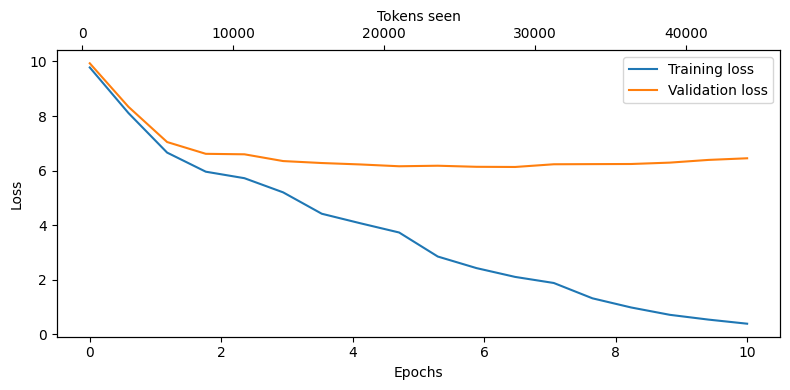

In [19]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

---

## Part 3: Loading Pretrained Weights [30 points]

In this part, you will learn how to load pretrained GPT-2 weights from OpenAI into your model.  
This is a crucial skill as it allows you to leverage powerful pretrained models without training from scratch.

### Question 3-1) Download Pretrained Weights [5 points]

First, we need to download the pretrained GPT-2 weights from OpenAI.

**HINT**
- Use `download_and_load_gpt2()` to download the **124M** parameter model.
- The weights will be saved in a local directory.

In [21]:
import os
import urllib.request
import json
import numpy as np
import tensorflow as tf

def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        if not os.path.exists(file_path):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(file_url, file_path)
        else:
            print(f"{filename} already exists, skipping download.")

    # Load settings and parameters
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Load parameters from TensorFlow checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process variable names and assign to params dictionary
        variable_name_parts = name.split("/")[1:]  # Skip 'model/' prefix

        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


# Download the pretrained GPT-2 124M model
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
print("Settings:", settings)
print("\nParameter dictionary keys:", params.keys())
print("Number of transformer blocks:", len(params["blocks"]))

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Number of transformer blocks: 12


### Understand Weight Structure

Explore the structure of the pretrained weights to understand how they map to your model.

- Examine the keys in the params dictionary.
- Look at the shape of different weight tensors.
- Compare with your model's architecture.

In [22]:
# Explore the structure of loaded parameters
print("Token embedding shape:", params["wte"].shape)
print("Position embedding shape:", params["wpe"].shape)

# Check first transformer block structure
print("\nFirst transformer block keys:", params["blocks"][0].keys())

# Check attention weights in first block
print("\nAttention weights shape:", params["blocks"][0]["attn"]["c_attn"]["w"].shape)
print("Attention bias shape:", params["blocks"][0]["attn"]["c_attn"]["b"].shape)

Token embedding shape: (50257, 768)
Position embedding shape: (1024, 768)

First transformer block keys: dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

Attention weights shape: (768, 2304)
Attention bias shape: (2304,)


### Question 3-2) Implement Weight Assignment [10 points]

Implement the function that assigns pretrained weights to your model.

**HINT**
- Use `.T` to transpose 2D weights when needed
-  If you are not sure where the weights of the position embedding are stored, check the immediately preceding block.
-  You can infer how to retrieve the weights and biases of `W_key` and `W_value` by looking at how the weights and bias of `W_query` are obtained.
-  The ff layers and norm layers each appear twice in every block. Compare them with the code that has already been written to infer what should go in the blanks.

In [23]:
def assign_weights(model, params):
    # Assign token and position embeddings
    model.tok_emb.weight = nn.Parameter(torch.tensor(params["wte"]))
    model.pos_emb.weight = nn.Parameter(torch.tensor(params["wpe"]))

    # Assign weights for each transformer block
    for block_num in range(len(params["blocks"])):
        # Attention weights (c_attn contains concatenated Q, K, V)
        q_w, k_w, v_w = np.split(params["blocks"][block_num]["attn"]["c_attn"]["w"], 3, axis=-1)
        model.trf_blocks[block_num].att.W_query.weight = nn.Parameter(torch.tensor(q_w).T)
        model.trf_blocks[block_num].att.W_key.weight = nn.Parameter(torch.tensor(k_w).T)
        model.trf_blocks[block_num].att.W_value.weight = nn.Parameter(torch.tensor(v_w).T)

        # Attention biases
        q_b, k_b, v_b = np.split(params["blocks"][block_num]["attn"]["c_attn"]["b"], 3, axis=-1)
        model.trf_blocks[block_num].att.W_query.bias = nn.Parameter(torch.tensor(q_b))
        model.trf_blocks[block_num].att.W_key.bias = nn.Parameter(torch.tensor(k_b))
        model.trf_blocks[block_num].att.W_value.bias = nn.Parameter(torch.tensor(v_b))

        # Attention output projection
        model.trf_blocks[block_num].att.out_proj.weight = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["attn"]["c_proj"]["w"]).T)
        model.trf_blocks[block_num].att.out_proj.bias = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["attn"]["c_proj"]["b"]))

        # Feed-forward weights (input projection)
        model.trf_blocks[block_num].ff.layers[0].weight = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["mlp"]["c_fc"]["w"]).T)
        model.trf_blocks[block_num].ff.layers[0].bias = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["mlp"]["c_fc"]["b"]))

        # Feed-forward weights (output projection)
        model.trf_blocks[block_num].ff.layers[2].weight = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["mlp"]["c_proj"]["w"]).T)
        model.trf_blocks[block_num].ff.layers[2].bias = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["mlp"]["c_proj"]["b"]))

        # Layer normalization (attention)
        model.trf_blocks[block_num].norm1.scale = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["ln_1"]["g"]))
        model.trf_blocks[block_num].norm1.shift = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["ln_1"]["b"]))

        # Layer normalization (feed-forward)
        model.trf_blocks[block_num].norm2.scale = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["ln_2"]["g"]))
        model.trf_blocks[block_num].norm2.shift = nn.Parameter(
            torch.tensor(params["blocks"][block_num]["ln_2"]["b"]))

    # Final layer normalization
    model.final_norm.scale = nn.Parameter(torch.tensor(params["g"]))
    model.final_norm.shift = nn.Parameter(torch.tensor(params["b"]))

    # Output layer (shares weights with token embedding in GPT-2)
    model.out_head.weight = nn.Parameter(torch.tensor(params["wte"]))


# Create a new model with context_length=1024 to match GPT-2
GPT_CONFIG_124M_PRETRAINED = {
    "vocab_size": 50257,
    "context_length": 1024,  # Increased to match GPT-2
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True  # GPT-2 uses bias for QKV
}

torch.manual_seed(123)
model_pretrained = GPTModel(GPT_CONFIG_124M_PRETRAINED)
assign_weights(model_pretrained, params)
model_pretrained.to(device)
model_pretrained.eval()

print("Pretrained weights loaded successfully!")

Pretrained weights loaded successfully!


### Question 3-3) Generate Text with Pretrained Model [5 points]

Test the pretrained model by generating text and compare it with your trained model.

**HINT**
- Use the same `generate_text_simple` function.
- Set the `max_new_tokens` value appropriately.
- Try different `start_contexts` to see the model's capabilities.

In [24]:
# Generate text with the pretrained model
start_contexts = [
    "Every effort moves you",
    "Hello, I am",
    "The future of AI is"
]

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 50)
print("TEXT GENERATION WITH PRETRAINED GPT-2")
print("=" * 50)

for context in start_contexts:
    encoded = text_to_token_ids(context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model_pretrained,
            idx=encoded,
            max_new_tokens=25,
            context_size=GPT_CONFIG_124M_PRETRAINED["context_length"]
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(f"\nPrompt: {context}")
    print(f"Generated: {decoded_text}")
    print("-" * 50)

TEXT GENERATION WITH PRETRAINED GPT-2

Prompt: Every effort moves you
Generated: Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the
--------------------------------------------------

Prompt: Hello, I am
Generated: Hello, I am a little bit of a fan of the original series. I have been a fan of the original series for a long time,
--------------------------------------------------

Prompt: The future of AI is
Generated: The future of AI is uncertain. The future of AI is uncertain.

The future of AI is uncertain. The future of AI is uncertain.
--------------------------------------------------


### Question 3-4) Text Generation Results [5 points]

Excluding the example sentences that were already provided, please present **three** of the prompts you entered along with their generated outputs.

In [ ]:
"""
Prompt: Every effort moves you
Generated: Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the
--------------------------------------------------

Prompt: Hello, I am
Generated: Hello, I am a little bit of a fan of the original series. I have been a fan of the original series for a long time,
--------------------------------------------------

Prompt: The future of AI is
Generated: The future of AI is uncertain. The future of AI is uncertain.

The future of AI is uncertain. The future of AI is uncertain.
"""

### Question 3-5) Generate Text with Pretrained Model [5 points]

Compare the output quality between your trained model and the pretrained model.  
What differences do you observe? Why do you think these differences exist?

In [ ]:
"""
1. 관찰된 차이점
직접 학습시킨 모델은 학습 데이터에 최적화되어 문학적인 문체(소설)를 보인다.
반면, 프리트레이닝된 GPT-2 모델은 현대적이고 일상적인 언어를 생성한다.

품질과 일관성: 직접 학습시킨 모델은 문장이 부자연스럽지만,
프리트레이닝된 모델은 일반적인 문장을 만들어낸다.
다만, 프리트레이닝된 모델에서도 특정 문구(ex. ~ step is to understand..., uncertain 등)가 반복되는 현상이 나타난다.

2. 차이가 존재하는 이유
직접 학습시킨 모델은 제한된 양의 텍스트(ex. 소설_the-verdict_한 권)로 학습되었으나,
프리트레이닝된 GPT-2는 방대한 WebText 데이터셋으로 학습해 자연스러운 언어 패턴을 익혔기 때문이다.

"""